In [1]:
import os

import lpips
import torch as th
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import cv2

from scripts import *

In [2]:
# important params
checkpoint_dir = "experiments/big_img/lightning_logs/version_1/checkpoints/epoch=774.ckpt"
save_path = "experiments/gan_inversion/dataaug_version_1_epoch=774"

os.makedirs(save_path, exist_ok=True)

# optional
bs = 64
n_iter = 1000
r, c = 32, 64

In [3]:
# load model
model = GAN.load_from_checkpoint(checkpoint_dir)
model.eval()
model.cuda()

GAN(
  (generator): BasicGenerator(
    (l1): Linear(in_features=100, out_features=4096, bias=True)
    (conv_blocks): Sequential(
      (0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Upsample(scale_factor=2.0, mode=nearest)
      (2): ConvBlock(
        (conv_block): ModuleList(
          (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2, inplace=True)
        )
      )
      (3): Upsample(scale_factor=2.0, mode=nearest)
      (4): ConvBlock(
        (conv_block): ModuleList(
          (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2, inplace=True)
        )
      )
      (5): Upsample(scale_fac

In [10]:
# fake data loader

# path names
X_fake_path = os.path.join(save_path, "X_fake.npy")
y_fake_path = os.path.join(save_path, "y_fake.npy")

if not os.path.exists(X_fake_path) or not os.path.exists(y_fake_path):
    y_fake = []
    X_fake = []

    with th.no_grad():
        for i in range(10):
            z = th.normal(0, 1, (1000, model.generator.latent_dim), device=model.device)
            x = model.generator(z)

            y_fake.append(z.detach().cpu())
            X_fake.append(x.detach().cpu())

    y_fake = th.cat(y_fake, axis=0)
    X_fake = th.cat(X_fake, axis=0)

    # save fake dataset
    np.save(X_fake_path, X_fake.detach().cpu().numpy())
    np.save(y_fake_path, y_fake.detach().cpu().numpy())
else:
    X_fake = th.tensor(np.load(X_fake_path))
    y_fake = th.tensor(np.load(y_fake_path))
dataset = TensorDataset(X_fake.detach().cpu(), y_fake.detach().cpu())
dataloader_fake = DataLoader(dataset, batch_size=bs, shuffle=True, num_workers=2)

y_fake.shape, X_fake.shape

(torch.Size([10000, 100]), torch.Size([10000, 3, 32, 64]))

In [11]:
# real data loader

X_real_path = os.path.join(save_path, "X_real.npy")

cars = np.load("../potsdam_data/potsdam_cars/cars.npy", allow_pickle=True)

if not os.path.exists(X_real_path):
    X_real = []
    for car in tqdm.tqdm(cars):
        car_resized = cv2.resize(car, (c, r)).transpose(2, 0, 1).astype(np.float32)

        # scaling -1, 1
        car_resized = 2*(car_resized / 255) - 1

        # append
        X_real.append(np.expand_dims(car_resized, axis=0))

    X_real = np.concatenate(X_real, axis=0)

    # save real dataset
    np.save(X_real_path, X_real)
else:
    X_real = np.load(X_real_path)

X_real = th.tensor(X_real, dtype=X_fake.dtype)

dataset = TensorDataset(X_real, X_real)
dataloader_real = DataLoader(dataset, batch_size=bs, shuffle=True, num_workers=2)

X_real.shape

torch.Size([4302, 3, 32, 64])

In [12]:
# val data loader

X_real_path = os.path.join(save_path, "X_real_val.npy")

cars = np.load("../potsdam_data/potsdam_cars_val/cars.npy", allow_pickle=True)

if not os.path.exists(X_real_path):
    X_real = []
    for car in cars:
        car_resized = cv2.resize(car, (c, r)).transpose(2, 0, 1).astype(np.float32)
        
        # scaling -1, 1
        car_resized = 2*(car_resized / 255) - 1

        # append
        X_real.append(np.expand_dims(car_resized, axis=0))
        
    X_real = np.concatenate(X_real, axis=0)

    # save real dataset
    np.save(X_real_path, X_real)
else:
    X_real = np.load(X_real_path)

X_real = th.tensor(X_real, dtype=X_fake.dtype)

dataset = TensorDataset(X_real, X_real)
dataloader_val = DataLoader(dataset, batch_size=2*bs, shuffle=True, num_workers=2)

X_real.shape

torch.Size([414, 3, 32, 64])

In [13]:
net = EncoderLatent(model.generator).cuda()
optimizer = th.optim.Adam(net.parameters(), lr=0.001)
loss_latent = th.nn.MSELoss(reduction="mean")
# loss_rec = th.nn.MSELoss(reduction="mean")
loss_rec = lpips.LPIPS(net='vgg').cuda()

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/hca/Documents/Master/Thesis/Master-Thesis/.env/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth


In [14]:
net

EncoderLatent(
  (generator): BasicGenerator(
    (l1): Linear(in_features=100, out_features=4096, bias=True)
    (conv_blocks): Sequential(
      (0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Upsample(scale_factor=2.0, mode=nearest)
      (2): ConvBlock(
        (conv_block): ModuleList(
          (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2, inplace=True)
        )
      )
      (3): Upsample(scale_factor=2.0, mode=nearest)
      (4): ConvBlock(
        (conv_block): ModuleList(
          (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2, inplace=True)
        )
      )
      (5): Upsample

In [13]:
net.train()

learning_curve = []
learning_curve_val = []
n_iter = 300

for i in range(n_iter):

    x_fake, z_fake = next(iter(dataloader_fake))
    x_real, _ = next(iter(dataloader_real))
    
    optimizer.zero_grad()
    z_fake_, x_fake_ = net.forward(x_fake.cuda())
    _, x_real_ = net.forward(x_real.cuda())


    loss_1 = loss_latent(z_fake_, z_fake.cuda())
    loss_2 = th.mean(loss_rec(x_fake_, x_fake.cuda(), normalize=True))
    loss_3 = th.mean(loss_rec(x_real_, x_real.cuda(), normalize=True))
    total_loss = loss_1 + loss_2 + loss_3
    
    learning_curve.append(total_loss.item())
    
    total_loss.backward()
    optimizer.step()
    
    if i % 10 == 0:
        print("iteration ", i, "loss", learning_curve[-1])
    
    if i % 90 == 0:
        for g in optimizer.param_groups:
            g['lr'] = g['lr']*0.1
    
    if i % 100 == 0:
        with th.no_grad():
            net.eval()
            l = 0
            for x_val, _ in dataloader_val:
                _, x_val_ = net.forward(x_val.cuda())
                l += th.mean(loss_rec(x_val_, x_val.cuda(), normalize=True)).item()
            print("iteration ", i, "val loss", l)
            learning_curve_val.append(l)
            net.train()
        th.save(net.state_dict(), os.path.join(save_path, f"iter={i}.pkl"))

iteration  0 loss 3.579294204711914
iteration  0 val loss 1.1205816864967346
iteration  10 loss 3.6765565872192383
iteration  20 loss 3.543285846710205
iteration  30 loss 3.5782687664031982
iteration  40 loss 3.5978572368621826
iteration  50 loss 3.5735960006713867
iteration  60 loss 3.680598258972168
iteration  70 loss 3.6113617420196533
iteration  80 loss 3.627056837081909
iteration  90 loss 3.686023235321045


Text(0, 0.5, 'MSE')

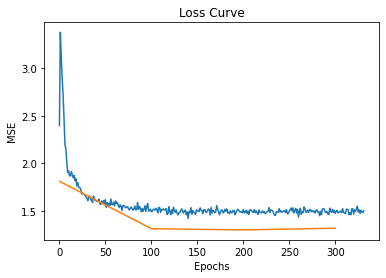

In [140]:
plt.plot(learning_curve)
plt.plot([100*i for i in range(len(learning_curve_val))], learning_curve_val)
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("MSE")

In [15]:
best_model_iter = 300
net.load_state_dict(th.load(os.path.join(save_path, f"iter={best_model_iter}.pkl")))
net.cuda()
net.eval()

EncoderLatent(
  (generator): BasicGenerator(
    (l1): Linear(in_features=100, out_features=4096, bias=True)
    (conv_blocks): Sequential(
      (0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Upsample(scale_factor=2.0, mode=nearest)
      (2): ConvBlock(
        (conv_block): ModuleList(
          (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2, inplace=True)
        )
      )
      (3): Upsample(scale_factor=2.0, mode=nearest)
      (4): ConvBlock(
        (conv_block): ModuleList(
          (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2, inplace=True)
        )
      )
      (5): Upsample

([], [])

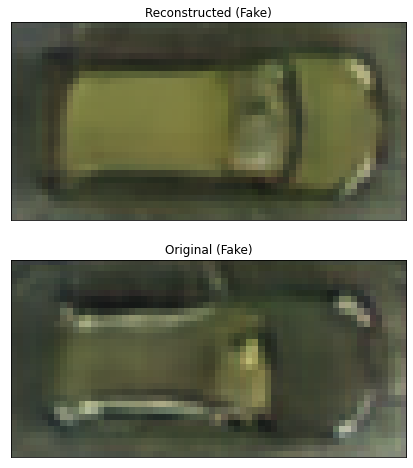

In [16]:
# testing
with th.no_grad():
    z = th.normal(0, 1, (1, model.generator.latent_dim), device=model.device)
    x_orig = model(z)

    z_rec, _ = net.forward(x_orig)
    x_rec = model.generator(z_rec)

# rescale
x_rec = (np.squeeze(x_rec.detach().cpu().numpy()).transpose(1, 2, 0) + 1) / 2
x_orig = (np.squeeze(x_orig.detach().cpu().numpy()).transpose(1, 2, 0) + 1) / 2

# plot
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.imshow(x_rec)
plt.title("Reconstructed (Fake)", fontsize=12)
plt.xticks([])
plt.yticks([])
plt.subplot(2, 1, 2)
plt.imshow(x_orig)
plt.title("Original (Fake)", fontsize=12)
plt.xticks([])
plt.yticks([])

([], [])

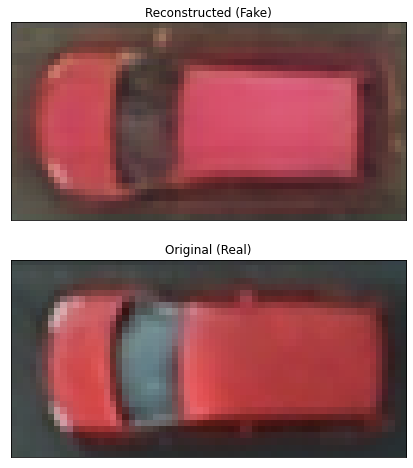

In [30]:
i = 1
x_val, _ = next(iter(dataloader_val))

x_orig = th.unsqueeze(x_val[i], axis=0)
z_rec, _ =  net.forward(x_orig.cuda())
x_rec = model.generator(z_rec)

# rescale
x_rec = (np.squeeze(x_rec.detach().cpu().numpy()).transpose(1, 2, 0) + 1) / 2
x_orig = (np.squeeze(x_orig.detach().cpu().numpy()).transpose(1, 2, 0) + 1) / 2

# plot
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.imshow(x_rec)
plt.title("Reconstructed (Fake)", fontsize=12)
plt.xticks([])
plt.yticks([])
plt.subplot(2, 1, 2)
plt.imshow(x_orig)
plt.title("Original (Real)", fontsize=12)
plt.xticks([])
plt.yticks([])